In [5]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Nominal trajectory, measurements

In [6]:
class MonoCamera:
    def control(self, X, t):
        u_g = np.sin(0.2*t)
        return u_g

    def f(self, X, t):
        g, d = X
        # control
        u_g = self.control(X, t)
        # dynamics
        g_dot = u_g
        d_dot = 0
        x_dot = [g_dot, d_dot]
        return x_dot

    def h(self, X, t):
        g, d = X
        y = g/d
        return np.atleast_2d(y)

    def simulate(self, x0, tsim):
        result = odeint(self.f, x0, tsim)
        X = result.T
        Y = self.h(X, tsim)
        return X, Y

In [7]:
sys = MonoCamera()

x0 = np.array([0, 3])
tsim = np.arange(0, 100, 0.01)

X, Y = sys.simulate(x0, tsim)

Text(0, 0.5, 'Measurement values')

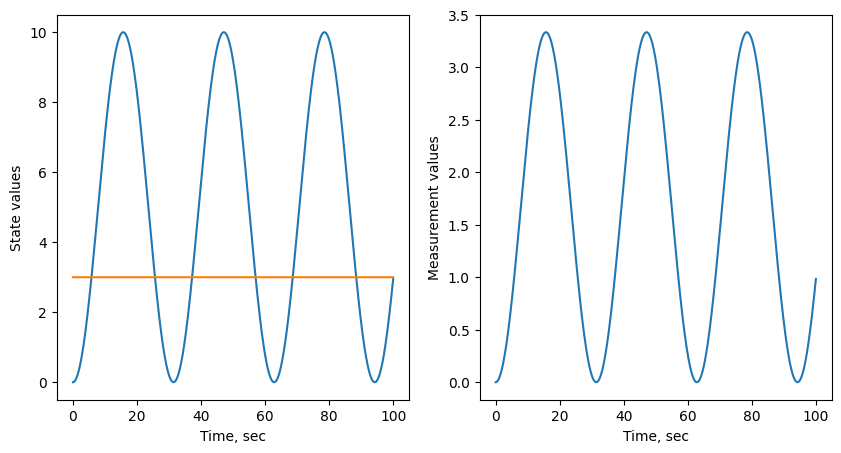

In [8]:
fig = plt.figure(figsize=(10,5))

# States
ax = fig.add_subplot(121)

ax.plot(tsim, X[0,:])
ax.plot(tsim, X[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('State values')

# Measurements
ax = fig.add_subplot(122)

ax.plot(tsim, Y[0,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Measurement values')

# Empirical Observability Matrix

In [9]:
def empirical_observability_matrix(system, x0, tsim, eps=1e-4):
    """ Empirically calculates the observability matrix O for a given system & input.

        Inputs
            system:             simulator object
            x0:                 initial state
            tsim:               simulation time
            usim:               simulation inputs
            eps:                amount to perturb initial state

        Outputs
            O:                  numerically calculated observability matrix
            X                   nominal trajectory simulation data
            deltay:             the difference in perturbed measurements at each time step
                                (basically O stored in a 3D array)
    """

    # Simulate once for nominal trajectory
    X, Y = system.simulate(x0, tsim)
    n_state = X.shape[0]  # number of states
    n_output = Y.shape[0]  # number of outputs

    # Calculate O
    w = len(tsim)  # of points in time window
    delta = eps * np.eye(n_state)  # perturbation amount for each state
    deltay = np.zeros((n_output, n_state, w))  # preallocate deltay
    for k in range(n_state):  # each state
        # Perturb initial condition in both directions
        x0plus = x0 + delta[:, k]
        x0minus = x0 - delta[:, k]

        # Simulate measurements from perturbed initial conditions
        _, yplus = system.simulate(x0plus, tsim)
        _, yminus = system.simulate(x0minus, tsim)

        # Calculate the numerical Jacobian & normalize by 2x the perturbation amount
        deltay[:, k, :] = np.array(yplus - yminus) / (2 * eps)

    # Construct O by stacking the 3rd dimension of deltay along the 1st dimension, O is a (p*m x n) matrix
    O = []  # list to store datat at each time point fo O
    for j in range(w):
        O.append(deltay[:, :, j])

    O = np.vstack(O)

    return O, X, deltay

# Sinusoidal trajectory

In [10]:
# Define system with sinusoidal trajectory
sys = MonoCamera()
def control(X, t):
    u_g = np.sin(0.2*t)
    return u_g
sys.control = control

# Establish initial condition and simulation times
x0 = np.array([0, 3])
tsim = np.arange(0, 100, 0.01)

# Get the empirical observability matrix
O, X, deltay = empirical_observability_matrix(sys, x0, tsim, eps=1e-4)

# Analyze O
W = O.T@O
eig = np.linalg.eigvals(W)
CN = np.max(eig) / np.min(eig)
print('Condition Number = ', CN)
print('')
print('Observability Gramian:')
print(W)

Condition Number =  15.198984936477414

Observability Gramian:
[[ 1116.73647178 -1771.89328235]
 [-1771.89328235  4376.55011383]]


In [11]:
np.linalg.inv(W)

array([[0.00250397, 0.00101376],
       [0.00101376, 0.00063892]])

# Constant velocity trajectory

In [19]:
# Define system with sinusoidal trajectory
sys = MonoCamera()
def control(X, t):
    u_g = 0
    return u_g
sys.control = control

# Establish initial condition and simulation times
x0 = np.array([1, 3])
tsim = np.arange(0, 100, 0.01)

# Get the empirical observability matrix
O, X, deltay = empirical_observability_matrix(sys, x0, tsim, eps=1e-4)

# Analyze O
W = O.T@O
eig = np.linalg.eigvals(W)
CN = np.max(eig) / np.min(eig)
print('Condition Number = ', CN)
print('')
print('Observability Gramian:')
print(W)

Condition Number =  -2.171874820781365e+16

Observability Gramian:
[[1111.11111111 -370.37037078]
 [-370.37037078  123.4567904 ]]


In [20]:
np.linalg.inv(W + 1e-5*np.eye(2))

array([[10000.00079736, 29999.99992867],
       [29999.99992867, 90000.00049581]])

In [21]:
t

NameError: name 't' is not defined

In [51]:
# Define system with sinusoidal trajectory
sys = MonoCamera()
def control(X, t):
    if t < 10:
      u_g = 0
    elif t < 50:
      u_g = np.sin(0.5*t)
    elif t < 80:
      u_g = 0
    else:
      u_g = 2
    return u_g
sys.control = control

# Establish initial condition and simulation times
x0 = np.array([10, 3])
tsim = np.arange(0, 100, 0.01)

# Get the empirical observability matrix
X, Y = sys.simulate(x0, tsim)

In [52]:
X.shape

(2, 10000)

Text(0, 0.5, 'Measurement values')

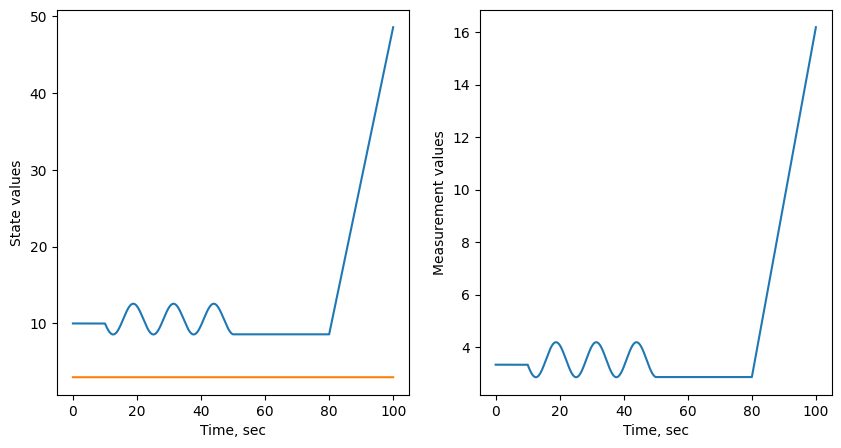

In [53]:
fig = plt.figure(figsize=(10,5))

# States
ax = fig.add_subplot(121)

ax.plot(tsim, X[0,:])
ax.plot(tsim, X[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('State values')

# Measurements
ax = fig.add_subplot(122)

ax.plot(tsim, Y[0,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Measurement values')

In [54]:
CRB_diags = []
window_size = 30

t0_windows = np.arange(0, 10000, 100)
for t0_window in t0_windows:
  x0_window = X[:, t0_window]
  tsim_window = tsim[t0_window:t0_window+window_size]

  O, _, deltay = empirical_observability_matrix(sys, x0_window, tsim_window, eps=1e-4)
  W = O.T@O
  CRB = np.linalg.inv(W + 1e-5*np.eye(2))
  CRB_diag = np.diag(CRB)
  CRB_diags.append(CRB_diag)

In [55]:
CRB_diags = np.vstack(CRB_diags)

In [56]:
CRB_diags.shape

(100, 2)

<Figure size 1000x500 with 0 Axes>

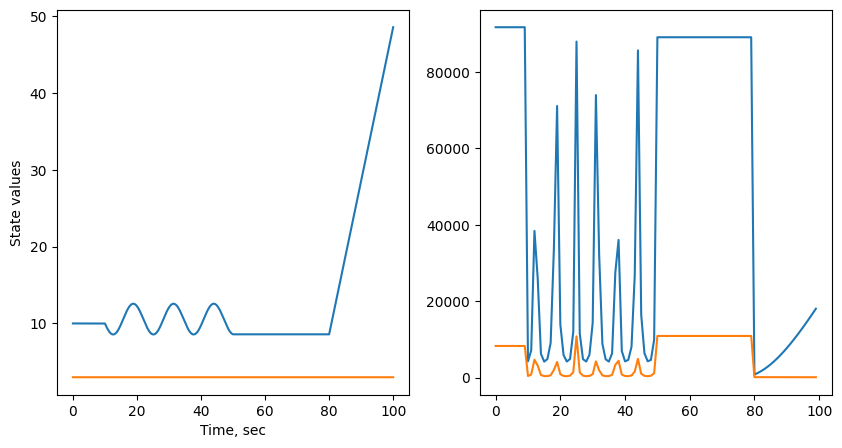

In [58]:
fig = plt.figure(figsize=(10,5))


fig = plt.figure(figsize=(10,5))

# States
ax = fig.add_subplot(121)

ax.plot(tsim, X[0,:])
ax.plot(tsim, X[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('State values')

# States
ax = fig.add_subplot(122)

ax.plot(tsim[t0_windows], CRB_diags[:,0])
ax.plot(tsim[t0_windows], CRB_diags[:,1])